In [1]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing

prefix = 'FTTBUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
os.chdir('..')

# input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
print(result)
# input_filename = 'input/test.csv'
output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

price_data = processing.import_binance_prices(path, result)[::120]
# price_data2 = processing.de_freq(price_data, 180)
# price_list = [None]*len(price_data)
final_price = price_data[-1]
price_data.extend([final_price] * 100)
price_list = [{'DOT':data.price} for data in price_data]
print(price_list[0:10])

# prefix = 'BTCBUSD'
# tick = '1s'

# path = 'input/'
# extension = 'csv'
# os.chdir(path)
# result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
# os.chdir('..')

# # input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
# print(result)
# # input_filename = 'input/test.csv'
# output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

# price_data = processing.import_binance_prices(path, result)[::1200]
# # price_data2 = processing.de_freq(price_data, 180)
# # price_list = [None]*len(price_data)
# final_price = price_data[-1]
# price_data.extend([final_price] * 100)
# price_list = [{'DOT':data.price} for data in price_data]
# print(price_list[0:10])

['FTTBUSD-1s-2022-11-07.csv', 'FTTBUSD-1s-2022-11-08.csv', 'FTTBUSD-1s-2022-11-09.csv']
[{'DOT': 22.26}, {'DOT': 22.25}, {'DOT': 22.29}, {'DOT': 22.24}, {'DOT': 22.26}, {'DOT': 22.41}, {'DOT': 22.32}, {'DOT': 22.3}, {'DOT': 22.37}, {'DOT': 22.46}]


In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamic_asset_fee, dynamic_lrna_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'AUSD': {'usd price': 1, 'weight': 0.10},
    'ETH': {'usd price': 1, 'weight': 0.40},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            lrna_fee=dynamic_lrna_fee(
                minimum=0.0025, 
                amplification=10 ** 11, 
                raise_oracle_name='fee_raise',
            ),
            oracles={'fee_raise': 500},  # , 'fee_lower': 7200},
            asset_fee=dynamic_asset_fee(
                minimum=0.0025,
                amplification=10 ** 11, 
                raise_oracle_name='fee_raise'
            ),
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool'
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    # evolve_function=fluctuate_prices(volatility={tkn: 1 for tkn in assets}),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # save_data = {
    #     'prices': pu.Datastream(asset='all'),
    #     # 'pool_val': pu.Datastream(pool='omnipool', prop='pool_val'),
    #     'asset_fee': pu.Datastream(pool='omnipool', prop='asset_fee', key='all'),
    #     'lrna_fee': pu.Datastream(pool='omnipool', prop='lrna_fee', key='all'),
    #     'LP returns': pu.Datastream(agent='LP', prop='cash_out')
    # }
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 2258 time steps
Starting simulation...
Execution time: 17.553 seconds.


<AxesSubplot:title={'center':'asset price: DOT '}>

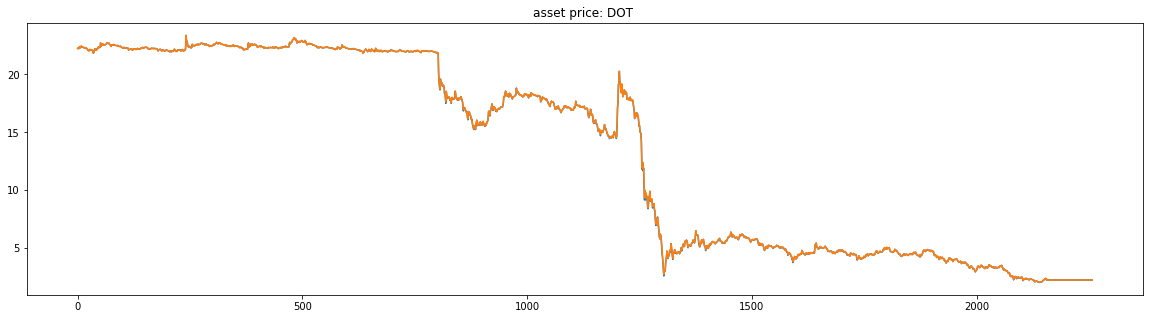

In [3]:
ax = pu.plot(events, asset='DOT')
pu.plot(events, pool='omnipool', prop='usd_price', key='DOT', subplot=ax)

:::FEES:::


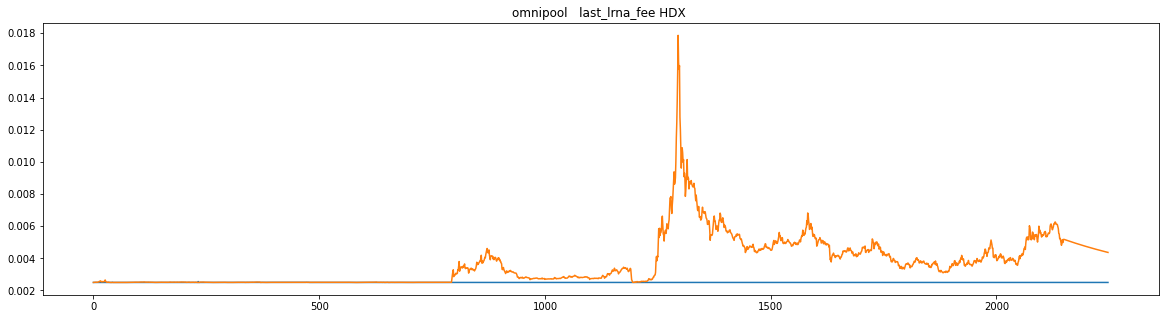

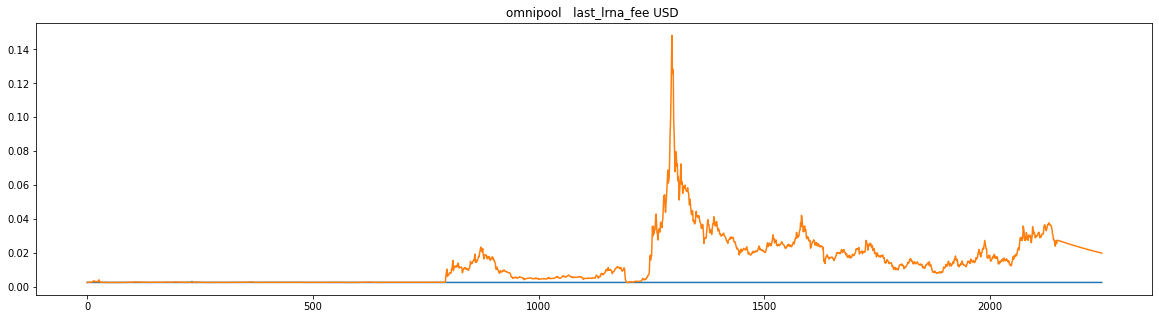

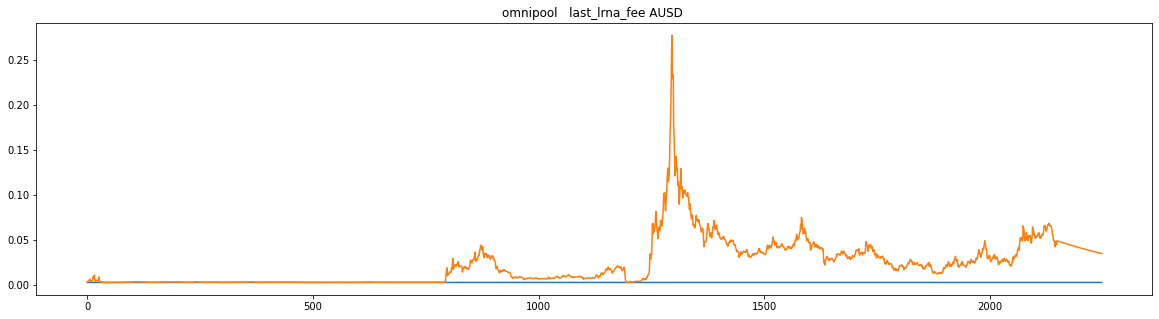

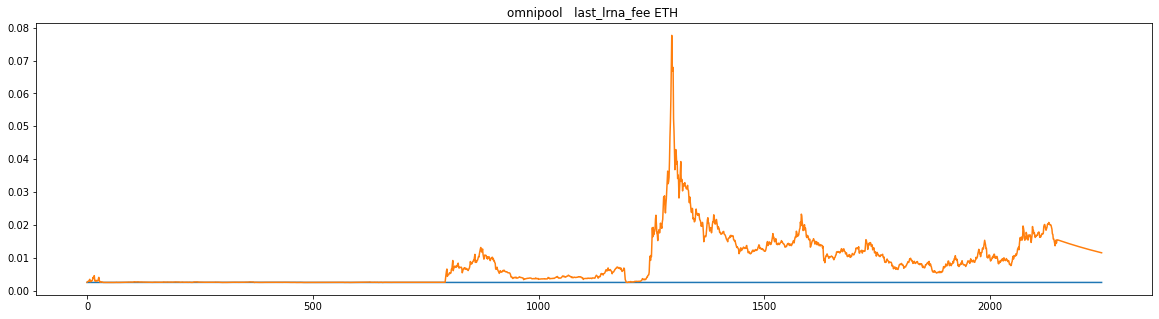

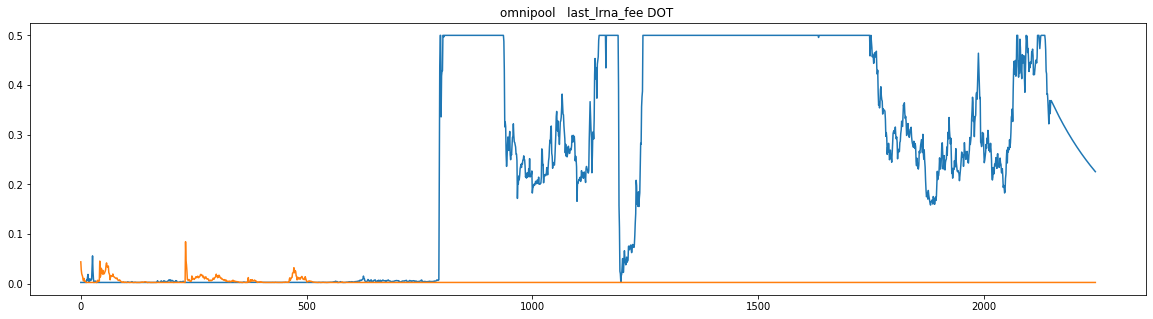

In [4]:
# print(events[0])
# dynamic_mult = [events[i]['state'].pools['omnipool'].last_mult for i in range(len(events))]
# plt.plot(range(len(dynamic_mult)), dynamic_mult)
# print(initial_state.pools['omnipool'].asset_list)
print(":::FEES:::")
# asset_fee = pu.get_datastream(events, pool='omnipool', prop='asset_fee', key='all')  # {tkn: [event['asset_fee'][tkn] for event in events[10:]] for tkn in assets}
# lrna_fee = pu.get_datastream(events, pool='omnipool', prop='lrna_fee', key='all')  # {tkn: [event['lrna_fee'][tkn] for event in events[10:]] for tkn in assets}
# print(lrna_fee['HDX'][1])
for tkn in initial_state.pools['omnipool'].asset_list:
    # print(tkn)
    # plt.figure(figsize=(20, 5))
    ax = pu.plot(events[10:], pool='omnipool', prop='last_lrna_fee', key=tkn)
    pu.plot(events[10:], pool='omnipool', prop='last_fee', key=tkn, subplot=ax)
    # plt.title(tkn)

In [5]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].lrna_fee = 0.0025
basic_state.pools['omnipool'].asset_fee = 0.0025

events2 = run.run(basic_state, time_steps=time_steps)
# events2 = processing.postprocessing(events2, optional_params=['withdraw_val'])

# print(events2[-1])
# feeless_arbitrageur = events2[-1]['state'].agents['Arbitrageur']

Starting simulation...
Execution time: 16.818 seconds.


Text(0.5, 1.0, 'LP with dynamic fees (blue) vs 0.25% flat (orange)')

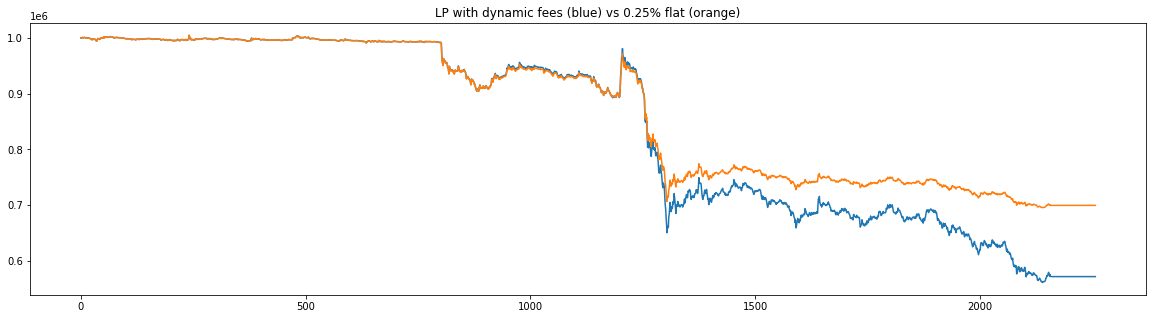

In [6]:
# lp_with_fees = pu.get_datastream(events, 'LP returns')
# lp_no_fees = pu.get_datastream(events2, 'LP returns')
ax = pu.plot(events, agent='LP', prop='cash_out')
pu.plot(events2, agent='LP', prop='cash_out', subplot=ax)
plt.title('LP with dynamic fees (blue) vs 0.25% flat (orange)')

In [7]:
# print(events[0], events[1000])

In [8]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events2[-1]['state'], events[-1]['state'].agents['LP']))

999910.1527403414084833599417834193445742130279541
571973.28480892814617808802251423583208673542131209
699651.85458254887585386321955854763283144331488185


In [9]:
print(initial_state)

global state 
pools: 

    Omnipool: omnipool
    ********************************
    tvl cap: inf
    lrna fee: Dynamic LRNA fee (oracle=fee_raise, amplification=100000000000, min=0.0025)
    asset fee: Dynamic fee (oracle=fee_raise, amplification=100000000000, min=0.0025)
    asset pools: (
    
        *HDX*
        asset quantity: 20000000.0
        lrna quantity: 14285714.285714284
        USD price: 0.714285714286
        tvl: $1000000.0
        weight: 14285714.285714284/142857142.85714284 (0.1)
        weight cap: 1.0
        total shares: 20000000.0
        protocol shares: 20000000.0
    
        *USD*
        asset quantity: 2000000.0
        lrna quantity: 28571428.571428567
        USD price: 14.285714285714
        tvl: $2000000.0
        weight: 28571428.571428567/142857142.85714284 (0.2)
        weight cap: 1.0
        total shares: 2000000.0
        protocol shares: 2000000.0
    
        *AUSD*
        asset quantity: 1000000.0
        lrna quantity: 14285714.2857142